Fetching data for AAPL...
Engineering Features (FracDiff, Yang-Zhang)...
Detecting Market Regimes (Unsupervised Learning)...

--- Regime Detection Stats (Mean Returns) ---
Regime
1   -0.004537
0    0.000871
2    0.003221
Name: Returns_Smoothed, dtype: float64
---------------------------------------------

Signals Generated.
--- Performance: AAPL ---
Total Return: 23.10%
Sharpe Ratio: 1.36

Plotting results... (Close window to finish)


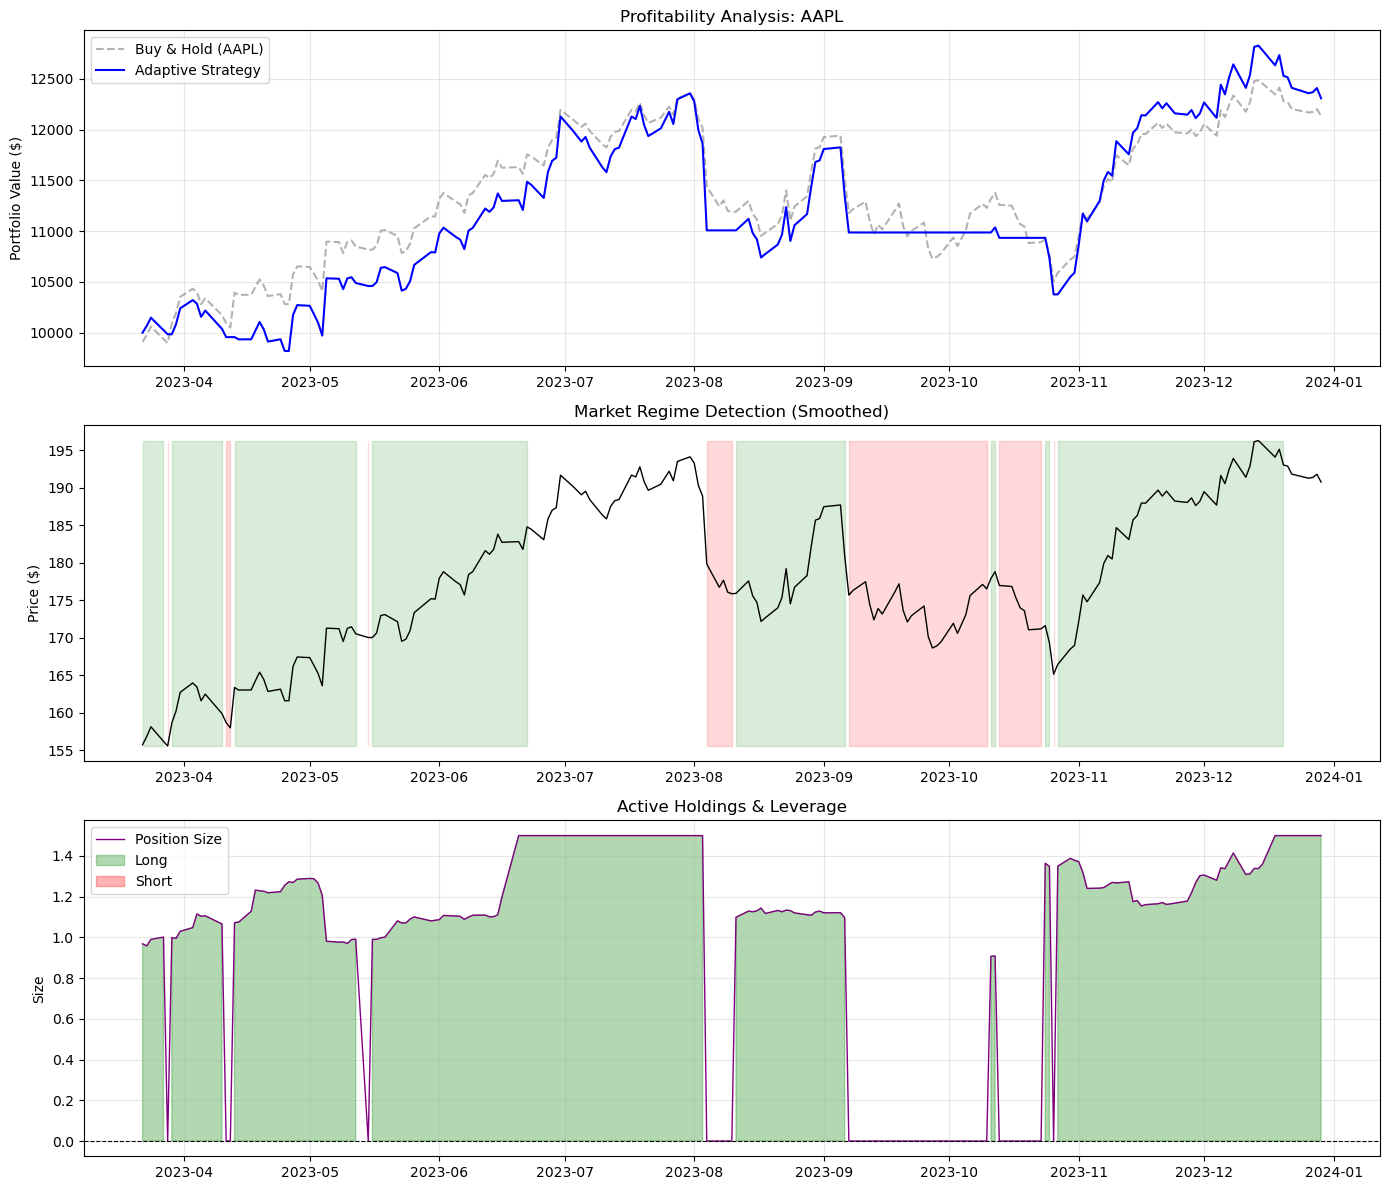

In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from abc import ABC, abstractmethod
import warnings

# Suppress warnings for cleaner output in a research environment
warnings.filterwarnings('ignore')

# ==========================================
# 1. ADVANCED FEATURE ENGINEERING (Math Lab)
# ==========================================

class FeatureLab:
    """
    Implements advanced signal processing techniques described in the MIT research plan.
    Includes Fractional Differentiation and Yang-Zhang Volatility.
    """

    @staticmethod
    def get_weights_frac_diff(d, size, threshold=1e-5):
        """
        Calculates weights for fractional differentiation using the binomial expansion.
        Ref: Section 2.1.1 of Research Plan.
        """
        w = [1.0]
        for k in range(1, size):
            w_k = -w[-1] / k * (d - k + 1)
            w.append(w_k)
        
        w = np.array(w[::-1])
        # optimize weights by cutting off small values
        w = w[np.abs(w) > threshold]
        return w

    @staticmethod
    def frac_diff_fixed(series, d, window=50):
        """
        Applies fractional differentiation to a pandas Series.
        Preserves memory while achieving stationarity.
        
        Updated: Increased default window to 50 for better stability on volatile assets.
        """
        weights = FeatureLab.get_weights_frac_diff(d, window)
        # Note: We use the full window of weights
        res = series.rolling(window=len(weights)).apply(lambda x: np.dot(x, weights), raw=True)
        return res

    @staticmethod
    def yang_zhang_volatility(df, window=30):
        """
        Computes Yang-Zhang Volatility: Minimum variance, unbiased, drift-independent.
        Ref: Section 2.2 of Research Plan.
        """
        log_ho = (df['High'] / df['Open']).apply(np.log)
        log_lo = (df['Low'] / df['Open']).apply(np.log)
        log_co = (df['Close'] / df['Open']).apply(np.log)
        
        log_oc = (df['Open'] / df['Close'].shift(1)).apply(np.log)
        log_cc = (df['Close'] / df['Close'].shift(1)).apply(np.log)
        
        rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)
        
        close_vol = log_cc.rolling(window=window).var()
        open_vol = log_oc.rolling(window=window).var()
        window_rs = rs.rolling(window=window).mean()

        k = 0.34 / (1.34 + (window + 1) / (window - 1))
        
        yz_vol = np.sqrt(open_vol + k * window_rs)
        return yz_vol

    @staticmethod
    def compute_relative_strength(series, window=14):
        """Standard RSI for Mean Reversion components."""
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

# ==========================================
# 2. MARKET REGIME DETECTION (Behavioral Lab)
# ==========================================

class RegimeIdentifier:
    """
    Uses Unsupervised Learning (GMM) to decode latent market states.
    Ref: Section 3.1 & 3.2 of Research Plan.
    """
    def __init__(self, n_components=3):
        # 3 components: 0=Bear/HighVol, 1=Sideways, 2=Bull/LowVol
        self.model = GaussianMixture(n_components=n_components, covariance_type="full", random_state=42)
        self.scaler = StandardScaler()
        self.is_fitted = False

    def fit_predict(self, df):
        """
        Fits GMM on Returns and Volatility to identify regimes.
        Returns the dataframe with a 'Regime' column.
        """
        data = df.copy().dropna()
        
        # IMPROVEMENT: Use Rolling Mean of Returns instead of Daily Returns.
        # Daily returns are too noisy and cause rapid regime flickering (whipsaw).
        # We want to classify the "Week" or "Trend", not the "Day".
        data['Returns_Smoothed'] = data['Returns'].rolling(window=5).mean()
        data['Volatility_Smoothed'] = data['Volatility'].rolling(window=5).mean()
        data.dropna(inplace=True)

        # Features for Regime Detection:
        X = data[['Returns_Smoothed', 'Volatility_Smoothed']].values
        
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        # Fit GMM
        self.model.fit(X_scaled)
        regimes = self.model.predict(X_scaled)
        
        data['Regime'] = regimes
        self.is_fitted = True
        
        # Map regimes based on Mean Return
        regime_stats = data.groupby('Regime')['Returns_Smoothed'].mean()
        
        # Sort: Lowest Return (Bear), Middle (Sideways), Highest (Bull)
        sorted_regimes = regime_stats.sort_values().index 
        
        print("\n--- Regime Detection Stats (Mean Returns) ---")
        print(regime_stats.sort_values())
        print("---------------------------------------------\n")

        mapping = {
            sorted_regimes[0]: -1, # Bear
            sorted_regimes[1]: 0,  # Sideways
            sorted_regimes[2]: 1   # Bull
        }
        
        data['Regime_Label'] = data['Regime'].map(mapping)
        return data

# ==========================================
# 3. STRATEGY ABSTRACTION
# ==========================================

class Strategy(ABC):
    """Abstract Base Class for all trading strategies."""
    
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.results = None

    def fetch_data(self):
        print(f"Fetching data for {self.ticker}...")
        try:
            self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date, progress=False, auto_adjust=False)
        except Exception as e:
            print(f"Warning: Download failed or returned empty: {e}")
            return

        if isinstance(self.data.columns, pd.MultiIndex):
            self.data.columns = self.data.columns.get_level_values(0)

        if 'Adj Close' not in self.data.columns:
            if 'Close' in self.data.columns:
                print("Note: 'Adj Close' column not found. Using 'Close' as fallback.")
                self.data['Adj Close'] = self.data['Close']
            else:
                raise KeyError(f"Neither 'Adj Close' nor 'Close' found for {self.ticker}.")

        self.data['Returns'] = self.data['Adj Close'].pct_change()
        self.data.dropna(inplace=True)

    @abstractmethod
    def generate_signals(self):
        pass

    def run_backtest(self, initial_capital=10000):
        """Vectorized Backtest Engine."""
        if 'Signal' not in self.data.columns:
            raise ValueError("Signals not generated yet.")
        
        df = self.data.copy()
        
        # Strategy Returns = Signal(t) * Returns(t+1)
        # Shift signal by 1 to align "Decision" with "Next Day Return"
        df['Strategy_Returns'] = df['Signal'].shift(1) * df['Returns']
        
        # Fill initial NaNs to avoid cumprod errors
        df['Strategy_Returns'].fillna(0, inplace=True)
        df['Returns'].fillna(0, inplace=True)
        
        df['Cumulative_Market'] = (1 + df['Returns']).cumprod() * initial_capital
        df['Cumulative_Strategy'] = (1 + df['Strategy_Returns']).cumprod() * initial_capital
        
        self.results = df
        return df

    def performance_metrics(self):
        df = self.results
        total_return = (df['Cumulative_Strategy'].iloc[-1] / df['Cumulative_Strategy'].iloc[0]) - 1
        # Calculate annualized Sharpe
        # Note: We use daily returns for Sharpe calculation
        daily_excess = df['Strategy_Returns']
        sharpe = (daily_excess.mean() / daily_excess.std()) * np.sqrt(252)
        
        print(f"--- Performance: {self.ticker} ---")
        print(f"Total Return: {total_return:.2%}")
        print(f"Sharpe Ratio: {sharpe:.2f}")
        return total_return, sharpe

# ==========================================
# 4. CONCRETE STRATEGY: ADAPTIVE REGIME
# ==========================================

class AdaptiveRegimeStrategy(Strategy):
    """
    Implements the core thesis: Different regimes require different logic.
    Ref: Section 1.1 & 3.3 of Research Plan.
    """

    def generate_signals(self):
        print("Engineering Features (FracDiff, Yang-Zhang)...")
        
        # 1. Calculate Advanced Features
        self.data['Volatility'] = FeatureLab.yang_zhang_volatility(self.data)
        # Increased window to 50 for stability
        self.data['FracDiff'] = FeatureLab.frac_diff_fixed(self.data['Adj Close'].apply(np.log), d=0.4, window=50)
        self.data['RSI'] = FeatureLab.compute_relative_strength(self.data['Adj Close'])
        
        self.data.dropna(inplace=True)
        
        # 2. Detect Regimes (Smoothed)
        print("Detecting Market Regimes (Unsupervised Learning)...")
        regime_engine = RegimeIdentifier()
        # Note: The fit_predict now uses smoothed returns internally
        self.data = regime_engine.fit_predict(self.data)
        
        # 3. Apply Regime-Specific Logic
        self.data['Signal'] = 0
        
        # --- Logic Definitions ---
        
        # BULL REGIME (1): Trend Following
        # Go Long if trend (FracDiff) is positive.
        bull_condition = (self.data['Regime_Label'] == 1) & (self.data['FracDiff'] > 0)
        self.data.loc[bull_condition, 'Signal'] = 1
        
        # SIDEWAYS REGIME (0): Mean Reversion (Dip Buying)
        # Buy oversold.
        sideways_long = (self.data['Regime_Label'] == 0) & (self.data['RSI'] < 40)
        self.data.loc[sideways_long, 'Signal'] = 1
        
        # BEAR REGIME (-1): Capital Preservation
        # Strict Cash.
        bear_condition = (self.data['Regime_Label'] == -1)
        self.data.loc[bear_condition, 'Signal'] = 0 
        
        # --- MOMENTUM OVERRIDE ---
        # Fix for AAPL: If we are in Sideways regime but RSI > 65, 
        # standard mean reversion says "Sell/Cash". 
        # But in a strong bull market, this misses the rally.
        # We add a rule: If FracDiff is VERY positive (Strong Memory Trend), 
        # ignore Sideways exit and STAY LONG unless RSI is Extreme (> 80).
        
        strong_trend_override = (self.data['Regime_Label'] == 0) & \
                                (self.data['FracDiff'] > 1e-4) & \
                                (self.data['RSI'] > 40) & \
                                (self.data['RSI'] < 80)
                                
        self.data.loc[strong_trend_override, 'Signal'] = 1

        # 4. Volatility Targeting (Position Sizing)
        target_vol = 0.15 / np.sqrt(252)
        self.data['Vol_Scaler'] = target_vol / self.data['Volatility']
        self.data['Vol_Scaler'] = self.data['Vol_Scaler'].clip(upper=1.5) 
        
        self.data['Signal'] = self.data['Signal'] * self.data['Vol_Scaler']

        print("Signals Generated.")

    def plot_results(self):
        plt.figure(figsize=(14, 12))
        
        # Subplot 1: Cumulative Returns
        ax1 = plt.subplot(3, 1, 1)
        ax1.plot(self.results['Cumulative_Market'], label=f'Buy & Hold ({self.ticker})', color='gray', alpha=0.6, linestyle='--')
        ax1.plot(self.results['Cumulative_Strategy'], label='Adaptive Strategy', color='blue', linewidth=1.5)
        ax1.set_title(f"Profitability Analysis: {self.ticker}")
        ax1.set_ylabel("Portfolio Value ($)")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Subplot 2: Regimes
        ax2 = plt.subplot(3, 1, 2, sharex=ax1)
        prices = self.data['Adj Close']
        y_min, y_max = prices.min(), prices.max()
        
        bull_mask = self.data['Regime_Label'] == 1
        bear_mask = self.data['Regime_Label'] == -1
        
        ax2.plot(prices, color='black', linewidth=1, label='Price')
        ax2.fill_between(self.data.index, y_min, y_max, where=bull_mask, color='green', alpha=0.15, label='Bull Regime')
        ax2.fill_between(self.data.index, y_min, y_max, where=bear_mask, color='red', alpha=0.15, label='Bear Regime')
        ax2.set_title("Market Regime Detection (Smoothed)")
        ax2.set_ylabel("Price ($)")
        
        # Subplot 3: Strategy Holdings
        ax3 = plt.subplot(3, 1, 3, sharex=ax1)
        signal = self.data['Signal']
        ax3.plot(signal, color='purple', linewidth=1, label='Position Size')
        ax3.fill_between(signal.index, signal, 0, where=(signal > 0), color='green', alpha=0.3, label='Long')
        ax3.fill_between(signal.index, signal, 0, where=(signal < 0), color='red', alpha=0.3, label='Short')
        ax3.axhline(0, color='black', linestyle='--', linewidth=0.8)
        ax3.set_title("Active Holdings & Leverage")
        ax3.set_ylabel("Size")
        ax3.legend(loc='upper left')
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# ==========================================
# 5. EXECUTION BLOCK
# ==========================================

if __name__ == "__main__":
    # Configuration
    TICKER = "AAPL" # Changed to AAPL for testing
    START = "2023-01-01"
    END = "2024-01-01"
    
    # Instantiate Strategy
    strategy = AdaptiveRegimeStrategy(TICKER, START, END)
    
    # Workflow
    try:
        strategy.fetch_data()
        strategy.generate_signals()
        strategy.run_backtest()
        strategy.performance_metrics()
        
        print("\nPlotting results... (Close window to finish)")
        strategy.plot_results()
        
    except Exception as e:
        print(f"An error occurred during execution: {e}")